In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2023-06-28 15:39:20.902269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation between -20 and 20 degrees
    width_shift_range=0.1,  # Random horizontal shift by 0.1 of the image width
    height_shift_range=0.1,  # Random vertical shift by 0.1 of the image height
    shear_range=0.2,  # Random shearing transformations
    zoom_range=0.2,  # Random zooming by up to 20%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping
    fill_mode='nearest'  # Fill points outside the input boundaries with the nearest value
)

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Potato/Train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 1200 files belonging to 3 classes.


2023-06-28 15:39:32.000434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 15:39:32.001543: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Potato/Test",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 300 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

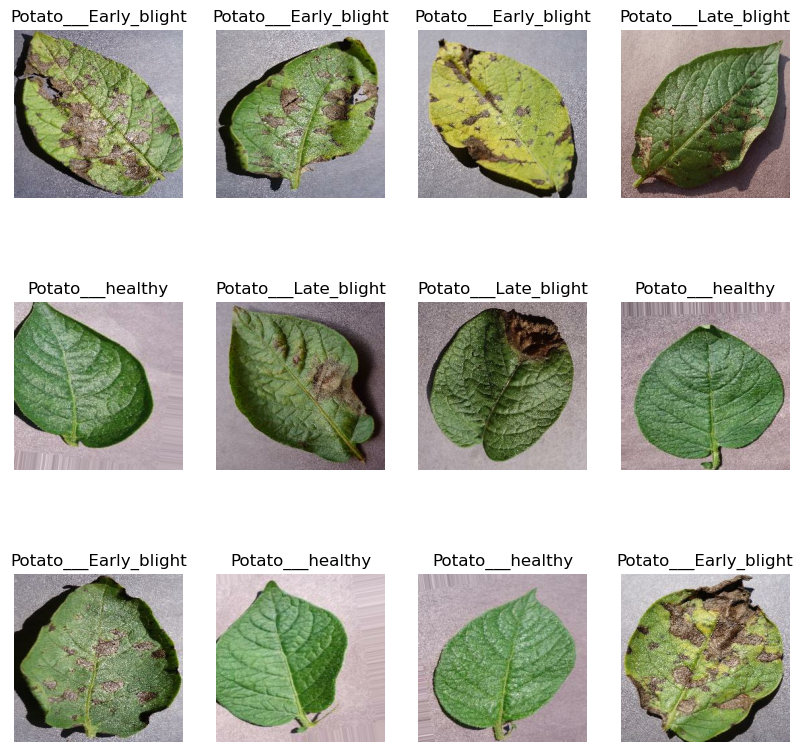

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    #print(image_batch.shape)
    #print(label_batch.numpy())

In [8]:
len(dataset)

38

In [9]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed =12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    return(train_ds, val_ds)

In [10]:
train_ds, val_ds = get_dataset_partition_tf(dataset)

In [11]:
len(dataset)

38

In [12]:
len(train_ds)

30

In [13]:
len(val_ds)

7

In [14]:
len(test_ds)

10

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [37]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_13 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
30/30 [==============================] - 88s 3s/step - loss: 1.0405 - accuracy: 0.4523 - val_loss: 0.7680 - val_accuracy: 0.6964
Epoch 2/50
30/30 [==============================] - 77s 3s/step - loss: 0.5968 - accuracy: 0.7203 - val_loss: 0.4440 - val_accuracy: 0.7768
Epoch 3/50
30/30 [==============================] - 77s 3s/step - loss: 0.3903 - accuracy: 0.8242 - val_loss: 0.3675 - val_accuracy: 0.8125
Epoch 4/50
30/30 [==============================] - 76s 3s/step - loss: 0.3832 - accuracy: 0.8453 - val_loss: 0.3764 - val_accuracy: 0.8348
Epoch 5/50
30/30 [==============================] - 77s 3s/step - loss: 0.3255 - accuracy: 0.8729 - val_loss: 0.2663 - val_accuracy: 0.8973
Epoch 6/50
 6/30 [=====>........................] - ETA: 1:09 - loss: 0.2233 - accuracy: 0.9115